## Get fasttext model and data

In [1]:
import fasttext.util
fasttext.util.download_model('nl', if_exists='ignore')  

'cc.nl.300.bin'

In [2]:
"""
Data from http://crr.ugent.be/archives/1330
"""

import os

if not os.path.exists('data/'):
    os.mkdir('data/')

!wget http://crr.ugent.be/papers/Concreteness%20ratings%20Brysbaert%20et%20al.xlsx -O data/ratings.xlsx

--2021-09-21 11:10:40--  http://crr.ugent.be/papers/Concreteness%20ratings%20Brysbaert%20et%20al.xlsx
Herleiden van crr.ugent.be (crr.ugent.be)... 157.193.153.14
Verbinding maken met crr.ugent.be (crr.ugent.be)|157.193.153.14|:80... verbonden.
HTTP-verzoek is verzonden; wachten op antwoord... 200 OK
Lengte: 1739705 (1,7M) [text/plain]
Wordt opgeslagen als: ‘data/ratings.xlsx’

data/ratings.xlsx   100%[===================>]   1,66M  1,60MB/s    in 1,0s    

2021-09-21 11:10:41 (1,60 MB/s) - '‘data/ratings.xlsx’' opgeslagen [1739705/1739705]



## Import packages

In [3]:
import sys
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import fasttext
import sklearn
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from scipy.stats import pearsonr

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
print(sys.version)

3.8.8 (default, Apr 13 2021, 12:59:45) 
[Clang 10.0.0 ]


In [5]:
for package in [sklearn, lightgbm, pd, np]:
    print(package.__name__, package.__version__)

sklearn 0.23.2
lightgbm 2.3.1
pandas 1.0.5
numpy 1.19.5


## Load data and retrieve embeddings

In [6]:
ft_model = fasttext.load_model('cc.nl.300.bin')

data = pd.read_excel('data/ratings.xlsx')
data = data.dropna(subset=['Concrete_m'])
    
data.head()

,stimulus,List,Concrete_m,Concrete_sd,Number_of_ratings,Number_of_N-respones,Number_of_subjects
0,aai,4,4.071429,1.206666,14,1,15
1,aaien,5,4.133333,0.990430,15,0,15
2,aak,1,4.666667,0.516398,6,9,15
3,aal,5,4.692308,0.630425,13,2,15
4,aalbes,2,4.733333,0.593617,15,0,15


In [7]:
X = np.zeros((len(data), ft_model.get_dimension()))
y = np.array(data['Concrete_m'])

for i, word in tqdm(enumerate(data['stimulus']),total=len(data)):
    X[i] = ft_model.get_word_vector(word)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=21)

  0%|          | 0/30065 [00:00<?, ?it/s]

## Train models

In [8]:
lr = LinearRegression()
svr = SVR(verbose=1)
lgbm = LGBMRegressor(verbose=1)

models = [lr, lgbm, svr]

for model in tqdm(models):
    model.fit(X_train, y_train)

  0%|          | 0/3 [00:00<?, ?it/s]

[LibSVM]

## Evaluate models

In [9]:
scores = []
preds = {}

for model in tqdm(models):
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    scoredict = dict(model=type(model).__name__,
                    r2_test = r2_score(y_test, y_pred_test),
                     r_test = pearsonr(y_test, y_pred_test)[0],
                     mae_test = mean_absolute_error(y_test, y_pred_test),
                    r_train = pearsonr(y_train, y_pred_train)[0],
                    )
    scores.append(scoredict)
    preds[type(model).__name__] = [y_pred_test, y_pred_train]

  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
results = pd.DataFrame(scores).set_index('model').sort_values('r2_test', ascending=False)

results

,r2_test,r_test,mae_test,r_train
model,,,,
SVR,0.741091,0.861016,0.393074,0.946258
LGBMRegressor,0.689290,0.830573,0.438475,0.892346
LinearRegression,0.619981,0.787511,0.498543,0.787328


## Visualize predictions of best model

Text(0, 0.5, 'Pred')

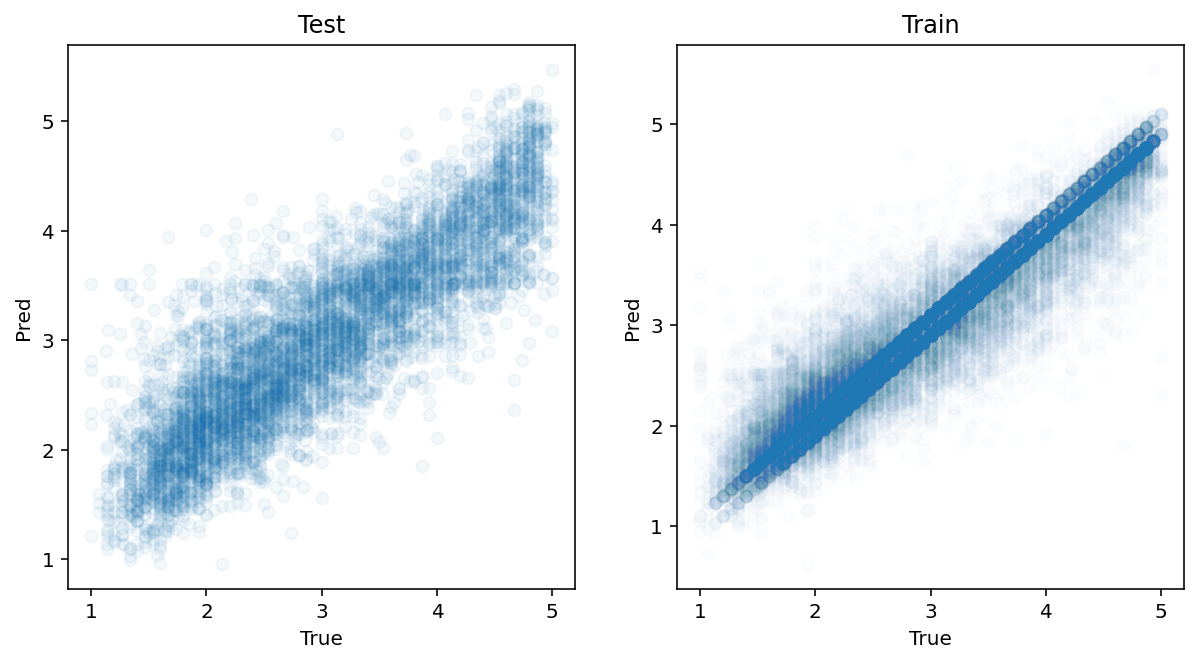

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

best_model = results.index[0]
y_pred_test, y_pred_train = preds[best_model]

axes[0].scatter(y_test, y_pred_test, alpha=0.05)
axes[0].set_title('Test')
axes[0].set_xlabel('True')
axes[0].set_ylabel('Pred')

axes[1].scatter(y_train, y_pred_train, alpha=0.01)
axes[1].set_title('Train')
axes[1].set_xlabel('True')
axes[1].set_ylabel('Pred')

## Save models using pickle

In [13]:
if not os.path.exists('models/'):
    os.mkdir('models/')

pickle.dump(svr, open('models/svr.p', 'wb'))
pickle.dump(lgbm, open('models/lgbm.p', 'wb'))